In [1]:
import random, warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score

from torch import nn

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from synexp import *
from viz import *
# from mlp import *

y0_pdf = 'sinusoid'
y1_pdf = 'low_base_rate_sinusoid'
pi_pdf = 'linear'

/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Example code invoking experiemnt setup functions
expdf, error_params = generate_syn_data(
    NS=5000,
    y0_pdf=y0_pdf,
    y1_pdf=y1_pdf,
    pi_pdf='linear',
    error_min=0.05,
    error_max=0.25
)

### Sanity check

In [2]:
expdf, error_params = generate_syn_data(
    NS=8000,
    y0_pdf=y0_pdf,
    y1_pdf=y1_pdf,
    pi_pdf='linear',
    error_min=0.2,
    error_max=0.25
)

In [3]:
results, val_scores = run_torch_experiment(expdf, do=0,
                                           error_params=error_params, n_epochs=20, train_ratio=.7)

100%|███████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]


In [5]:
results

{'model': ['Y', 'YD', 'Y_0', 'YS_0'],
 'AU-ROC': [0.8291978503405898,
  0.8669373881832628,
  0.8935143514351435,
  0.9145497883121645]}

100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


<AxesSubplot:xlabel='model', ylabel='AU-ROC'>

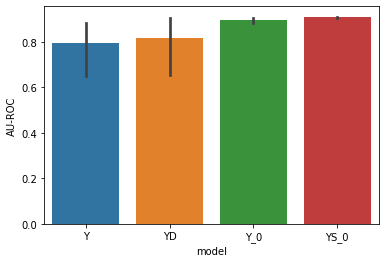

In [29]:
NS = 8000
N_RUNS = 5

exp_results = {
    'model': [],
    'AU-ROC': []
}

for RUN in range(N_RUNS):

    expdf, error_params = generate_syn_data(
        NS,
        y0_pdf='sinusoid',
        y1_pdf='low_base_rate_sinusoid',
        pi_pdf='linear',
        error_min=0.05,
        error_max=0.25
    )

    results, val_scores = run_torch_experiment(expdf, do=0, n_epochs=20)
    exp_results['model'].extend(results['model'])
    exp_results['AU-ROC'].extend(results['AU-ROC'])
    
resultdf = pd.DataFrame(exp_results)

In [ ]:
sns.barplot(data=resultdf, x='model', y='AU-ROC')

## Parameter estimation experiment

In [ ]:
loss_func = nn.BCELoss()

preds = torch.Tensor([.2,.3,.4])[:,None]
targets = torch.Tensor([0,0,1])[:,None]

nn.BCELoss(preds, targets)
preds.size()
targets.size()

In [2]:
N_RUNS = 10

results = []
SAMPLE_SIZES = [2000, 4000, 6000, 8000, 10000, 20000, 30000]

for NS in SAMPLE_SIZES:
    for RUN in range(N_RUNS):
        expdf, error_params = generate_syn_data(
            NS,
            y0_pdf=y0_pdf,
            y1_pdf=y1_pdf,
            pi_pdf=pi_pdf,
            error_min=0.05,
            error_max=0.25
        )
        exp_result = run_param_estimation_exp(expdf, error_params, n_epochs=20)    
        results.append(exp_result)


100%|███████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


<AxesSubplot:xlabel='NS'>

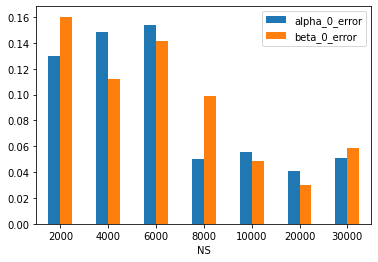

In [3]:
# Plot sanity check -- assert error converges as sample size increases

meandf = estimation_df.groupby('NS').mean()
meandf[['alpha_0_error', 'beta_0_error']].plot.bar(rot=0)

<AxesSubplot:xlabel='NS', ylabel='beta_0_error'>

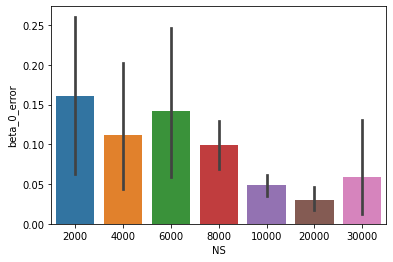

In [8]:

estimation_df = pd.DataFrame(results)
sns.barplot(data=estimation_df, x='NS', y='beta_0_error')

## Visualize class probability estimates

In [14]:
do=0
debug_info = {
    'val_x': val_scores['Y']['x'],
    'val_py': val_scores['Y']['py_hat']
}

viz_ccpe_estimates(expdf, debug_info, error_params, do, y0_pdf, y1_pdf, pi_pdf)

NameError: name 'val_scores' is not defined

### Prototype surrogate loss

In [13]:
def get_loss(y_hat, y, alpha_d=None, beta_d=None):

    loss_func = torch.nn.BCELoss()
    if not alpha_d:
        return loss_func(y_hat, y) 
        
    pos_loss = loss_func(y_hat[y==1], y[y==1])
    neg_loss = loss_func(y_hat[y==0], y[y==0])

    pos_label_losses = ((1-alpha_d)*pos_loss - beta_d*neg_loss)/(1-beta_d-alpha_d)
    neg_label_losses = ((1-beta_d)*neg_loss - alpha_d*pos_loss)/(1-beta_d-alpha_d)

    return pos_label_losses + neg_label_losses


alpha_d = 0.05
beta_d = 0.10

yhat = torch.rand((5000,1))
y = torch.Tensor(expdf['Y_0'].to_numpy())[:,None]


get_loss(y_hat, y, alpha_d=None, beta_d=None)



tensor(1.0194)